pt 2 of exploration_analysis.

wil try to read df with 4 pps, split per groups and do cross val. 

if this works i can then look into some tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pykalman import KalmanFilter
import os


In [2]:
#should read in some sort of processed df, exported from exploration analysis notebook. since im not doing it the next cells are just filling in NAs
# df = pd.read_csv('all_data_4pps.csv')

dir_in = 'D:\\arxeia\\AI_VU\\THESIS_internship\\3-experimental\\data\\allSensors_allPPs'
os.chdir(dir_in)
# df = pd.read_csv('all_data_FINAL.csv')

df = pd.read_csv('all_data_final_kalmanFilled.csv')

In [3]:
num_cols = ['AU1_InnerBrowRaiser', 'AU2_OuterBrowRaiser', 'AU4_BrowLowerer', 'AU5_UpperLipRaiser', 'AU6_CheekRaiser', 'AU7_LidTightener', 'AU9_NoseWringler', 'AU10_UpperLipRaiser', 'AU12_LipCornerPuller',
 'AU14_Dimpler','AU15_LipCornerDepressonr', 'AU17_ChinRaiser', 'AU20_LipStretcher', 'AU23_LipTightener', 'AU25_LipsPart', 'AU26_JawDrop', 'AU45_BlinkInt', 'AUc45_BlinkRate', 'AUc28_LipSuck',
 'headOrient_x', 'headOrient_y', 'headOrient_z', 'gazeCenter', 'gazeUp', 'gazeDown', 'gazeRight', 'gazeLeft', 'duration', 'Rclick', 'Lclick', 'move_dist', 'move_duration', 'move_speed',
 'scroll_dur', 'keyPress', 'press_dur', 'backsp', 'backsp_dur', 'pause_dur', 'pause_rate']

feature_cols = ['AU1_InnerBrowRaiser', 'AU2_OuterBrowRaiser', 'AU4_BrowLowerer', 'AU5_UpperLipRaiser', 'AU6_CheekRaiser', 'AU7_LidTightener', 'AU9_NoseWringler', 'AU10_UpperLipRaiser', 'AU12_LipCornerPuller',
 'AU14_Dimpler','AU15_LipCornerDepressonr', 'AU17_ChinRaiser', 'AU20_LipStretcher', 'AU23_LipTightener', 'AU25_LipsPart', 'AU26_JawDrop', 'AU45_BlinkInt', 'AUc45_BlinkRate', 'AUc28_LipSuck',
 'headOrient_x', 'headOrient_y', 'headOrient_z', 'gazeCenter', 'gazeUp', 'gazeDown', 'gazeRight', 'gazeLeft', 'Rclick', 'Lclick', 'keyPress', 'move_dist','move_duration']

# feature_cols = num_cols

In [4]:
   # Very simple Kalman filter: fill missing values and remove outliers for single attribute.
    # We assume a very simple transition matrix, namely simply a [[1]]. It
    # is however still useful as it is able to dampen outliers and impute missing values. The new
    # values are appended in a new column when replaceCol=False
# RETURNS THE SAME DF THAT IT RECEIVED AS INPUT-to make it work pp-wise
def apply_kalman_filter(df, col, replaceCol = False):

    # df = df2.copy()
    # df = df2#if u pass in sub-df, due to looping over pps dont copy (so that changes are also on the big main df)
    

    # Initialize the Kalman filter with the trivial transition and observation matrices.
    kf = KalmanFilter(transition_matrices=[[1]], observation_matrices=[[1]])

    numpy_array_state = df[col].values
    numpy_array_state = numpy_array_state.astype(np.float32)
    numpy_matrix_state_with_mask = np.ma.masked_invalid(numpy_array_state)

    # Find the best other parameters based on the data (e.g. Q)
    kf = kf.em(numpy_matrix_state_with_mask, n_iter=5)

    # And apply the filter.
    (new_data, filtered_state_covariances) = kf.filter(numpy_matrix_state_with_mask)

    if replaceCol:
        df[col] = new_data
    else:
        df[col + '_kalman'] = new_data
    return df


# #applying it to all num cols -NOT PP WISE SO WRONG
# for col in df.select_dtypes(include='number').columns:
for col in feature_cols:
    df = apply_kalman_filter(df, col, replaceCol=True)
    

In [5]:
# df.to_csv('all_data_kalmanFiltered.csv')

### plotting parthesis

In [85]:
# df.groupby(['pp_id','condition'])['pause_dur'].mean()
# pd.DataFrame(df.loc[df['condition']=='N'].groupby('pp_id')['pause_dur'].mean()).to_csv('N_pause_dur.csv')
# pd.DataFrame(df.loc[df['condition']=='S'].groupby('pp_id')['pause_dur'].mean()).to_csv('S_pause_dur.csv')
# pd.DataFrame(df.loc[df['condition']=='N'].groupby('pp_id')['pause_rate'].mean()).to_csv('N_pause_rate.csv')
# pd.DataFrame(df.loc[df['condition']=='S'].groupby('pp_id')['pause_rate'].mean()).to_csv('S_pause_rate.csv')

In [90]:
# np.array(df.loc[df['condition']=='N'].groupby('pp_id')['pause_dur'].mean())

array([1.3213815 , 1.66392318, 5.02892486, 0.4522358 , 0.95929351,
       1.03119827, 1.27734558, 1.0054066 , 1.03219088, 1.83528143,
       1.30160244, 3.65707662, 1.31380884, 6.15320204, 0.83503574,
       0.42146644, 1.24162432, 2.80669849, 5.22961142, 1.41445905])

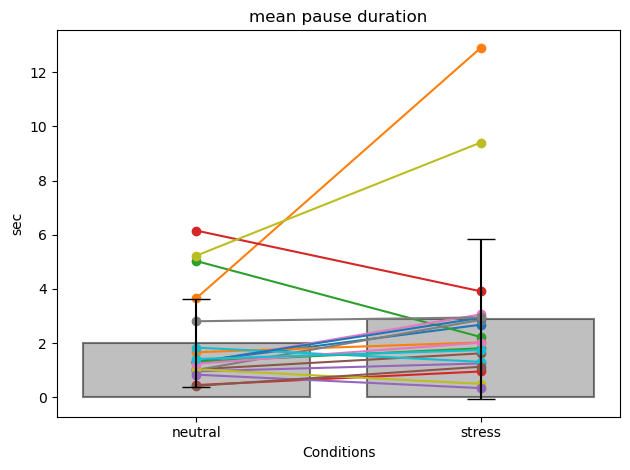

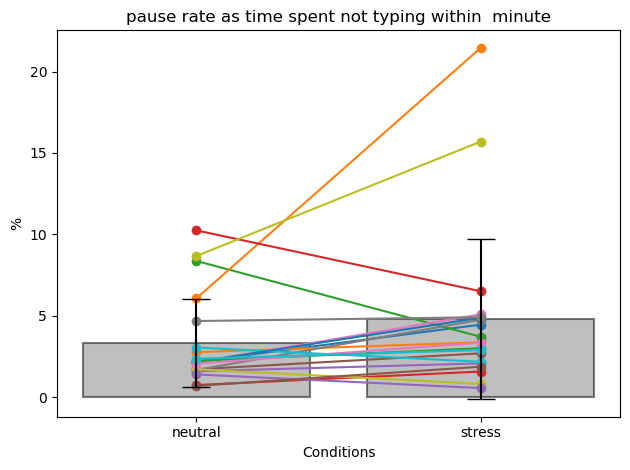

In [92]:
def plot_mean_bar_indiv_lines(cond1_array, cond2_array, title, ylabel):
    for i in range(len(cond1_array)):
        plt.plot([0,1], [cond1_array[i], cond2_array[i]], 'o-', label=('pp_idx_'+str(i)))
    
    # Add the mean values to the plot as bars, with stdev as error
    error = [np.std(cond1_array), np.std(cond2_array)]
    plt.bar([0, 1], [np.nanmean(cond1_array), np.nanmean(cond2_array)], yerr=error, color='gray', alpha=0.5, edgecolor='black', linewidth=1.5, capsize=10)

    # Add labels and title
    plt.xlabel('Conditions')
    plt.xticks(ticks=[0,1], labels=['neutral','stress'])
    plt.ylabel(ylabel)
    plt.title(title)

    # Add legend and show the plot
    # plt.legend()
    plt.tight_layout()
    plt.show()

# plot_mean_bar_indiv_lines(np.array(df.loc[df['condition']=='N'].groupby('pp_id')['pause_dur'].mean()),\
#                 np.array(df.loc[df['condition']=='S'].groupby('pp_id')['pause_dur'].mean()) , \
#             title='mean pause duration' , ylabel = 'sec')

# plot_mean_bar_indiv_lines(np.array(df.loc[df['condition']=='N'].groupby('pp_id')['pause_rate'].mean()),\
#             np.array(df.loc[df['condition']=='S'].groupby('pp_id')['pause_rate'].mean()),\
#             title = 'pause rate as time spent not typing within  minute', ylabel='%' )

In [55]:
df.to_csv('all_data_final_kalmanFilled.csv')

## modeling

In [12]:
from sklearn.model_selection import train_test_split ,cross_val_score,RandomizedSearchCV, cross_validate, StratifiedKFold
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn import svm
# from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [96]:
len(num_cols)
# len(feature_cols)

40

### splitting per group, & CV (no tuning)

In [97]:
x = df[feature_cols] 
y = df['condition']

models = [svm.SVC( random_state=42), KNeighborsClassifier(), DecisionTreeClassifier(random_state=41), RandomForestClassifier(random_state=43)]

model = models[0]

PPgroups = df['pp_id'].copy().tolist()

#initial splitting,splitting ONCE.  this test will be used for final testing. the train will be split further in CV
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=43)
for train_index, test_index in gss.split(x, y, groups=PPgroups):
    print('a test-train split')
    x_train = x.iloc[train_index, :]
    x_test = x.iloc[test_index, :]
    y_train = y[train_index]
    y_test = y[test_index]
    pp_groups_trainOnly = df.iloc[train_index]['pp_id'] #will have one pp less than PPgroups!
    print('done splitting')

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

scores = cross_val_score(model, x_train_scaled, y_train, groups = pp_groups_trainOnly, scoring='accuracy', cv=GroupKFold(n_splits=5)) #n_splits should be less than groups/pps!
print(model)
print('cross val scores: {}'.format(scores))

#then can train on full data & check performance on test set (never seen before). IT IS ONLY PREDICTING STRESS!!
print('now training on full data and predicting on test set(never seen before)DOING THIS ONLY ONCE!')
model.fit(x_train_scaled, y_train)
y_pred = model.predict(x_test_scaled)
print('\n classification  report on full data (run only once!)')
print(classification_report(y_test, y_pred))


a test-train split
done splitting
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)
cross val scores: [0.6875     0.57777778 0.59444444 0.49444444 0.53333333]
now training on full data and predicting on test set(never seen before)DOING THIS ONLY ONCE!

 classification  report on full data (run only once!)
              precision    recall  f1-score   support

           N       0.52      0.49      0.51       120
           S       0.52      0.55      0.53       120

    accuracy                           0.52       240
   macro avg       0.52      0.52      0.52       240
weighted avg       0.52      0.52      0.52       240



In [58]:
set(y_pred)

{'N', 'S'}

In [59]:
# checking pp distribution in train and test
for train_index, test_index in gss.split(x, y, groups = df['pp_id']): 
    print('a split:')
    print('train')
    print(set(df.iloc[train_index]['pp_id']))
    # print((df.iloc[train_index]['pp_id']))
    print('test')
    print(set(df.iloc[test_index]['pp_id'] ))
    # print((df.iloc[test_index]['pp_id'] ))

a split:
train
{'pp22', 'pp25', 'pp11', 'pp23', 'pp04', 'pp07', 'pp06', 'pp16', 'pp12', 'pp15', 'pp17', 'pp02', 'pp18', 'pp05', 'pp03', 'pp24'}
test
{'pp26', 'pp09', 'pp19', 'pp13'}


### first split to train and test (per group), train_scaled will be used for all models tuning +CV

In [5]:
x = df[feature_cols] 
y = df['condition']

# models = [svm.SVC( random_state=42), KNeighborsClassifier(), DecisionTreeClassifier(random_state=41), RandomForestClassifier(random_state=43)]

# model = models[0]

PPgroups = df['pp_id'].copy().tolist()

#initial splitting, this test will be used for final testing. the train will be split further in CV
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=43)
for train_index, test_index in gss.split(x, y, groups=PPgroups):
    print('a test-train split')
    x_train = x.iloc[train_index, :]
    x_test = x.iloc[test_index, :]
    y_train = y[train_index]
    y_test = y[test_index]
    pp_groups_trainOnly = df.iloc[train_index]['pp_id'] #will have one(or some) pp less than PPgroups!
    print('done splitting')

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
######################################################### maybe make the above into function

a test-train split
done splitting


### SVM: splitting per group + CV tuning 

In [44]:



# List of C values
C_range = np.logspace(-10, 10, 21)
# List of gamma values
gamma_range = np.logspace(-10, 10, 21)

# Define the search space
param_grid = { 
    # Regularization parameter.
    "C": C_range,
    # Kernel type
    "kernel": ['rbf', 'poly'],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": gamma_range.tolist()+['scale', 'auto']
}
# Set up score
scoring = ['accuracy']

# Set up the k-fold cross-validation
gkfold = GroupKFold(n_splits = 2)

# Define random search
random_search_svm = RandomizedSearchCV(estimator= svm.SVC( random_state=42), 
                           param_distributions= param_grid, 
                           n_iter= 100,
                           scoring= ['accuracy'], 
                           refit= 'accuracy', 
                           n_jobs= -1, 
                           cv= GroupKFold(n_splits = 5), #n_splits should be less than groups/pps!
                           verbose=0,
                           random_state=42)

# Fit grid search
random_result_svm = random_search_svm.fit(x_train_scaled, y_train, groups= pp_groups_trainOnly) 

# print('printing_result of random search cv')
# random_result

a test-train split
done splitting


In [45]:
print(f'SVM: The best accuracy score for the training dataset is {random_result_svm.best_score_:.4f}')

print(f'The best hyperparameters are {random_result_svm.best_params_}')
# Print the best accuracy score for the testing dataset
print(f'The accuracy score for the testing dataset is {random_search_svm.score(x_test_scaled, y_test):.4f}') #!!!!!!!!!!!!!!!!!!!!!
# print('printing results')
# random_result.cv_results_
# random_result_svm.cv_results_['params'] #the params used

SVM: The best accuracy score for the training dataset is 0.6361
The best hyperparameters are {'kernel': 'rbf', 'gamma': 1e-07, 'C': 10000.0}
The accuracy score for the testing dataset is 0.4667


In [100]:
len(df.iloc[train_index][df['pp_id']=='pp02'])

C:\Users\lefko\AppData\Local\Temp\ipykernel_1124\3218109032.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df.iloc[train_index][df['pp_id']=='pp02'])


60

In [64]:
# df.iloc[train_index].to_csv('traindf.csv')
# df.iloc[tr_index].to_csv('traindf.csv')

In [12]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(5, 5))
# plt.hist(y_train, bins=10, alpha=0.5, label='Train Data', color = 'red')
# plt.hist(y_test, bins=10, alpha=0.5, label='Test Data', color = 'blue')
# plt.xlabel('condition')
# plt.ylabel('Count')
# plt.title('Distribution of labels (conditions) in Train and Test Data')
# plt.legend()
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(5, 5))
# plt.hist(df.iloc[train_index]['pp_id'],  alpha=0.5, label='Train Data', color = 'red')
# plt.hist(df.iloc[test_index]['pp_id'],  alpha=0.5, label='Test Data', color = 'blue')
# plt.xlabel('condition')
# plt.ylabel('Count')
# plt.title('Distribution of labels (conditions) in Train and Test Data')
# plt.xticks(rotation=90)
# plt.legend()
# plt.tight_layout()
# plt.show()

### RF: splitting per group + CV tuning (on data already split+scaled above)

In [46]:
# i already have x_train, y train (2b used for random search cv) and x test, y test

params_rf={'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
                  'criterion':['gini','entropy'],
                  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]}

random_search_rf = RandomizedSearchCV(estimator= RandomForestClassifier(random_state=43), 
                           param_distributions= params_rf, 
                           n_iter= 100,
                           scoring= ['accuracy'], 
                           refit= 'accuracy', 
                           n_jobs= -1, 
                           cv= GroupKFold(n_splits = 5), 
                           verbose=0,
                           random_state=42)

# Fit grid search
random_result_rf = random_search_rf.fit(x_train_scaled, y_train, groups= pp_groups_trainOnly) 

print(f'RF: The best accuracy score for the training dataset is {random_search_rf.best_score_:.4f}')

print(f'The best hyperparameters are {random_result_rf.best_params_}')
# Print the best accuracy score for the testing dataset
print(f'The accuracy score for the testing dataset is {random_search_rf.score(x_test_scaled, y_test):.4f}') #!!!!!!!!!!!!!!!!!!!!!
# print('printing results')
# random_result.cv_results_
# random_result_rf.cv_results_['params'] #the params used
 

RF: The best accuracy score for the training dataset is 0.5783
The best hyperparameters are {'n_estimators': 800, 'max_depth': 10, 'criterion': 'entropy'}
The accuracy score for the testing dataset is 0.4708


### DT: splitting per group + CV tuning (on data already split+scaled above)

4 tree graph: https://www.kaggle.com/code/gauravduttakiit/hyperparameter-tuning-in-decision-trees

In [6]:


# i already have x_train, y train (2b used for random search cv) and x test, y test

params_dt={
    'max_depth': [2, 3, 5, 10, 20, 50, 100, 150, 200, 300, 500],
    'min_samples_leaf': [5, 10, 20, 50, 100, 200, 500],
    'criterion': ["gini", "entropy"]}


random_search_dt = RandomizedSearchCV(estimator= DecisionTreeClassifier(random_state=41), 
                           param_distributions= params_dt, 
                           n_iter= 100,
                           scoring= ['accuracy'], 
                           refit= 'accuracy', 
                           n_jobs= -1, 
                           cv= GroupKFold(n_splits = 5), 
                           verbose=0,
                           random_state=42)

# Fit grid search
random_result_dt = random_search_dt.fit(x_train_scaled, y_train, groups= pp_groups_trainOnly) 

print(f'DT: The best accuracy score for the training dataset is {random_search_dt.best_score_:.4f}')

print(f'The best hyperparameters are {random_result_dt.best_params_}')
# Print the best accuracy score for the testing dataset
print(f'The accuracy score for the testing dataset is {random_search_dt.score(x_test_scaled, y_test):.4f}') #!!!!!!!!!!!!!!!!!!!!!
# print('printing results')
# random_result.cv_results_
# random_result_rf.cv_results_['params'] #the params used
 

DT: The best accuracy score for the training dataset is 0.6544
The best hyperparameters are {'min_samples_leaf': 200, 'max_depth': 500, 'criterion': 'entropy'}
The accuracy score for the testing dataset is 0.5792


### K Nearest Neighbors: splitting per group + CV tuning (on data already split+scaled above)

https://www.kaggle.com/code/arunimsamudra/k-nn-with-hyperparameter-tuning

In [48]:

# i already have x_train, y train (2b used for random search cv) and x test, y test

params_knn={ 'n_neighbors' : list(range(1, 31)),
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}


random_search_knn = RandomizedSearchCV(estimator= KNeighborsClassifier(), 
                           param_distributions= params_knn, 
                           n_iter= 100,
                           scoring= ['accuracy'], 
                           refit= 'accuracy', 
                           n_jobs= -1, 
                           cv= GroupKFold(n_splits = 5), 
                           verbose=0,
                           random_state=42)

# Fit grid search
random_result_knn = random_search_knn.fit(x_train_scaled, y_train, groups= pp_groups_trainOnly) 

print(f'The best accuracy score for the training dataset is {random_search_knn.best_score_:.4f}')

print(f'The best hyperparameters are {random_result_knn.best_params_}')
# Print the best accuracy score for the testing dataset
print(f'The accuracy score for the testing dataset is {random_search_knn.score(x_test_scaled, y_test):.4f}') #!!!!!!!!!!!!!!!!!!!!!
# print('printing results')
# random_result_knn.cv_results_
# random_result_knn.cv_results_['params'] #the params used
 

The best accuracy score for the training dataset is 0.5894
The best hyperparameters are {'weights': 'uniform', 'n_neighbors': 28, 'metric': 'euclidean'}
The accuracy score for the testing dataset is 0.4458


### MLP: splitting per group + CV tuning (on data already split+scaled above)

https://www.kaggle.com/code/arunimsamudra/k-nn-with-hyperparameter-tuning

In [13]:
from sklearn.neural_network import MLPClassifier
# i already have x_train, y train (2b used for random search cv) and x test, y test

params_mlp={
    'hidden_layer_sizes': [(10,30,10),(20,), (7,), (1,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.005, 0.05],
    'learning_rate': ['constant','adaptive'],
}


random_search_mlp = RandomizedSearchCV(estimator= MLPClassifier(random_state=42, max_iter=100), 
                           param_distributions= params_mlp, 
                           n_iter= 100,
                           scoring= ['accuracy'], 
                           refit= 'accuracy', 
                           n_jobs= -1, 
                           cv= GroupKFold(n_splits = 5), 
                           verbose=0,
                           random_state=42)

# Fit grid search
random_result_mlp = random_search_mlp.fit(x_train_scaled, y_train, groups= pp_groups_trainOnly) 

print(f'MLP: The best accuracy score for the training dataset is {random_search_mlp.best_score_:.4f}')

print(f'The best hyperparameters are {random_result_mlp.best_params_}')
# Print the best accuracy score for the testing dataset
print(f'The accuracy score for the testing dataset is {random_search_mlp.score(x_test_scaled, y_test):.4f}') #!!!!!!!!!!!!!!!!!!!!!

MLP: The best accuracy score for the training dataset is 0.6031
The best hyperparameters are {'solver': 'sgd', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (20,), 'alpha': 0.05, 'activation': 'tanh'}
The accuracy score for the testing dataset is 0.4833


d:\programs\anaconda-navigator\actuslprogrm\envs\ml4qs\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


# exploring best model (DT) label distribution and plotting tree

Precision — What percent of your predictions were correct?== apafta pou leei stress posa einai odws stress? \\ low precision--> many FP

Recall — What percent of the positive cases did you catch? == posa apo ta alhthina stress kanei predict ws stress \\ low rcall--> many FN

F1 score — What percent of positive predictions were correct? harmonic mean of precision and recall

Support is the number of actual occurrences of the class in the specified dataset.

In [7]:
y_pred_dt = random_result_dt.predict(x_test_scaled)

              precision    recall  f1-score   support

           N       0.55      0.89      0.68       120
           S       0.71      0.27      0.39       120

    accuracy                           0.58       240
   macro avg       0.63      0.58      0.53       240
weighted avg       0.63      0.58      0.53       240

confusion matrix)
[[107  13]
 [ 88  32]]


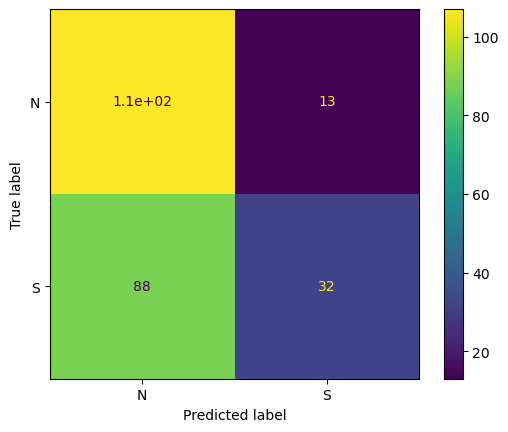

In [14]:
print(classification_report(y_test, y_pred_dt))
print('confusion matrix)')
print(confusion_matrix(y_test, y_pred_dt))

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_dt), display_labels=['N','S'])
disp.plot()
plt.show()

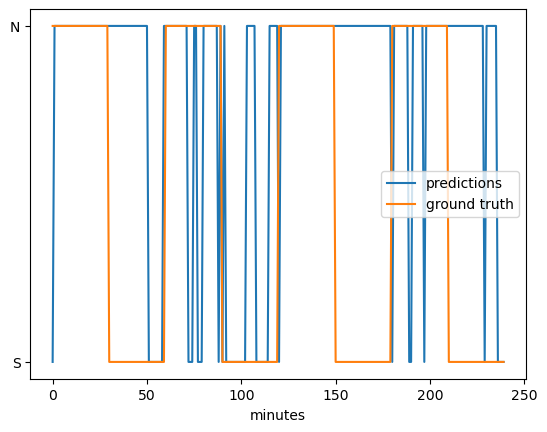

In [17]:
x_axis = np.array(range(len(df.iloc[test_index])))
plt.plot(x_axis, y_pred_dt, label='predictions')
plt.plot(x_axis, y_test, label='ground truth')
plt.xlabel('minutes')
plt.legend()
plt.show()


 ## plotting tree

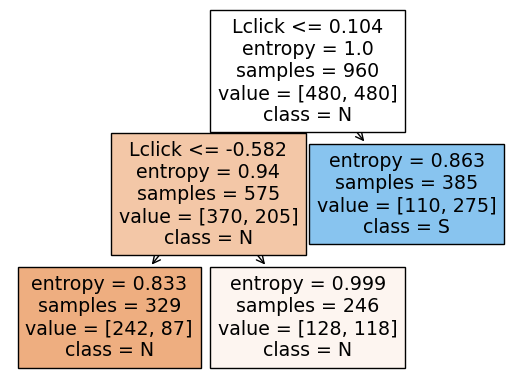

In [15]:
from sklearn import tree
# fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(random_result_dt.best_estimator_,
                   feature_names = feature_cols,
                   class_names = ['N','S'],
                   max_depth=500,
                  #  class_names = True,
                   filled=True)

In [20]:
print(random_result_dt.best_estimator_.tree_.compute_feature_importances())
print(len(random_result_dt.best_estimator_.tree_.compute_feature_importances()))
print(len(feature_cols))
feature_cols



[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0.]
32
32


['AU1_InnerBrowRaiser',
 'AU2_OuterBrowRaiser',
 'AU4_BrowLowerer',
 'AU5_UpperLipRaiser',
 'AU6_CheekRaiser',
 'AU7_LidTightener',
 'AU9_NoseWringler',
 'AU10_UpperLipRaiser',
 'AU12_LipCornerPuller',
 'AU14_Dimpler',
 'AU15_LipCornerDepressonr',
 'AU17_ChinRaiser',
 'AU20_LipStretcher',
 'AU23_LipTightener',
 'AU25_LipsPart',
 'AU26_JawDrop',
 'AU45_BlinkInt',
 'AUc45_BlinkRate',
 'AUc28_LipSuck',
 'headOrient_x',
 'headOrient_y',
 'headOrient_z',
 'gazeCenter',
 'gazeUp',
 'gazeDown',
 'gazeRight',
 'gazeLeft',
 'Rclick',
 'Lclick',
 'keyPress',
 'move_dist',
 'move_duration']

# creating personalised models (1model per pp) of the best, tuned DT